<a href="https://colab.research.google.com/github/jpgarciaortiz/DWT-ANN/blob/main/test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Previous steps


Download MRVC code from GitHub

In [ ]:
!(cd MRVC && git pull) || git clone https://github.com/jpgarciaortiz/MRVC.git

/bin/bash: line 0: cd: MRVC: No such file or directory
Cloning into 'MRVC'...
remote: Enumerating objects: 5143, done.
remote: Counting objects: 100% (930/930), done.
remote: Compressing objects: 100% (247/247), done.
remote: Total 5143 (delta 686), reused 922 (delta 678), pack-reused 4213
Receiving objects: 100% (5143/5143), 203.96 MiB | 33.10 MiB/s, done.
Resolving deltas: 100% (2654/2654), done.


Add the MRVC to the source path

In [ ]:
import sys
sys.path.append("MRVC/src")

Install additional packages

In [ ]:
!pip install colored ISR 'h5py<3.0.0' > /dev/null 2>&1

Import packages

In [ ]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pylab
%matplotlib inline
import image_3 as image
import image_1 as component
import DWT
import pywt
import distortion
import YCoCg as YUV
import deadzone as Q
import math
import information
import numpy as np
from PIL import Image

# Test code

Function to write DWT decomposition to PNG

In [ ]:
def write_compact_decomposition16(decom, prefix, image_number):
    rows = decom[len(decom)-1][0].shape[0]*2
    cols = decom[len(decom)-1][0].shape[1]*2
    coms = decom[0].shape[2]
    image_shape = (rows, cols, coms)
    view = np.empty(image_shape, np.uint16)

    # LL subband
    view[0:decom[0].shape[0],
         0:decom[0].shape[1]] = (decom[0].astype(np.int32) + 32768).astype(np.uint16)

    for l in range(len(decom)-1):

        # LH
        view[0:decom[l+1][0].shape[0],
             decom[l+1][0].shape[1]:decom[l+1][0].shape[1]*2] =\
                (decom[l+1][0].astype(np.int32) + 32768).astype(np.uint16)

        # HL
        view[decom[l+1][1].shape[0]:decom[l+1][1].shape[0]*2,
             0:decom[l+1][1].shape[1]] =\
                (decom[l+1][1].astype(np.int32) + 32768).astype(np.uint16)

        # HH
        view[decom[l+1][2].shape[0]:decom[l+1][2].shape[0]*2,
             decom[l+1][2].shape[1]:decom[l+1][2].shape[1]*2] =\
                (decom[l+1][2].astype(np.int32) + 32768).astype(np.uint16)
            
    return image.write(view, prefix, image_number)
    

def write_compact_decomposition(decom, prefix, image_number):
    rows = decom[len(decom)-1][0].shape[0]*2
    cols = decom[len(decom)-1][0].shape[1]*2
    coms = decom[0].shape[2]
    image_shape = (rows, cols, coms)
    view = np.empty(image_shape, np.uint8)

    # LL subband
    view[0:decom[0].shape[0],
         0:decom[0].shape[1]] = (decom[0].astype(np.int16) + 128).astype(np.uint16)

    for l in range(len(decom)-1):

        # LH
        view[0:decom[l+1][0].shape[0],
             decom[l+1][0].shape[1]:decom[l+1][0].shape[1]*2] =\
                (decom[l+1][0].astype(np.int16) + 128).astype(np.uint16)

        # HL
        view[decom[l+1][1].shape[0]:decom[l+1][1].shape[0]*2,
             0:decom[l+1][1].shape[1]] =\
                (decom[l+1][1].astype(np.int16) + 128).astype(np.uint16)

        # HH
        view[decom[l+1][2].shape[0]:decom[l+1][2].shape[0]*2,
             decom[l+1][2].shape[1]:decom[l+1][2].shape[1]*2] =\
                (decom[l+1][2].astype(np.int16) + 128).astype(np.uint16)
            
    return image.write(view, prefix, image_number)

Read the image

In [ ]:
x = image.read('MRVC/sequences/lena_color/')
#Image.fromarray(x)

Wavelet parameters

In [ ]:
N_levels = 1
wavelet = pywt.Wavelet("Haar")
#wavelet = pywt.Wavelet("db1")
#wavelet = pywt.Wavelet("db5")
#wavelet = pywt.Wavelet("db15")
#wavelet = pywt.Wavelet("bior3.1")
#wavelet = pywt.Wavelet("bior3.3")
#wavelet = pywt.Wavelet("bior5.5")

In [ ]:
y = DWT.analyze(x, wavelet, N_levels)
#z = DWT.synthesize(y, wavelet, N_levels).astype(np.uint8)

In [ ]:
len0 = write_compact_decomposition(y, 'test', 0)
print(f'File length 0: {len0} bytes')

File length 0: 531583 bytes


In [ ]:
ll = y[0]
lh = y[1][0]
hl = y[1][1]
hh = y[1][2]

In [ ]:
ll_i = (image.normalize(ll) * 255.0).astype('uint8')
#Image.fromarray(ll_i)

In [ ]:
from ISR.models import RDN

rdn = RDN(weights='psnr-small')
ll_i2 = rdn.predict(ll_i)
#Image.fromarray(ll_i2)

10698752/10694096 [==============================] - 1s 0us/step


In [ ]:
yp = DWT.analyze(ll_i2, wavelet, N_levels)

In [ ]:
lhp = yp[1][0]
hlp = yp[1][1]
hhp = yp[1][2]

In [ ]:
yp[0] = ll
yp[1] = (lh - lhp, hl - hlp, hh - hhp)


In [ ]:
len1 = write_compact_decomposition(yp, 'test', 1)
print(f'File length 1: {len1} bytes')

File length 1: 526409 bytes


In [ ]:
dif = len0 - len1
gain = (dif * 100) / len0
print(f'Compression gain: {gain:.2}%')

Compression gain: 0.97%


In [26]:
N_components = 3
xx = YUV.from_RGB(x.astype(np.int16) - 128) # -128 decreases maximum value of the DC coefficients
yy = DWT.analyze(xx, wavelet, N_levels)

print('sbc maximum mininum max-min average std-dev entropy        energy  avg-enegy')

entropy = information.entropy(yy[0].flatten().astype(np.int16))
accumulated_entropy = entropy * yy[0].size
print(f"  0 {yy[0].max():7.1f} {yy[0].min():7.1f} {yy[0].max()-yy[0].min():7.1f} {np.average(yy[0]):7.1f} {math.sqrt(np.var(yy[0])):7.1f} {entropy:7.1f} {information.energy(yy[0]):13.1f} {information.energy(yy[0])/yy[0].size:10.1f}")
sbc_index = 1
for sr in yy[1:]:
    for sb in sr:
        for c in range(N_components):
            sbc = sb[..., c]
            entropy = information.entropy(sbc.flatten().astype(np.int16))
            accumulated_entropy += (entropy * sbc.size)
            max = sbc.max()
            min = sbc.min()
            max_min = max - min
            print(f"{sbc_index:3d} {max:7.1f} {min:7.1f} {max_min:7.1f} {np.average(sbc):7.1f} {math.sqrt(np.var(sbc)):7.1f} {entropy:7.1f} {information.energy(sbc):13.1f} {information.energy(sbc)/sbc.size:10.1f}")
            sbc_index += 1

avg_entropy = accumulated_entropy / x.size

print('')
print(f'Average entropy in the wavelet domain: {avg_entropy:.4f}')
print(f'Entropy in the image domain: {information.entropy(x.flatten().astype(np.uint8)):.4f}')

sbc maximum mininum max-min average std-dev entropy        energy  avg-enegy
  0   211.0  -195.0   406.0     5.7    75.1     7.9  1116673462.0     5679.7
  1    84.5   -69.5   154.0     0.0     7.1     4.2     3314513.3       50.6
  2    43.0   -37.5    80.5     0.0     3.6     3.5      838024.8       12.8
  3    27.0   -21.5    48.5     0.0     2.2     2.7      310100.0        4.7
  4   116.0  -116.5   232.5    -0.1    10.4     4.7     7076651.3      108.0
  5    36.5   -36.5    73.0     0.1     4.4     3.9     1289745.8       19.7
  6    25.5   -32.5    58.0    -0.0     2.6     3.0      440958.0        6.7
  7    38.0   -42.0    80.0     0.0     4.1     3.6     1093170.3       16.7
  8    30.0   -37.5    67.5    -0.0     3.0     3.3      608267.8        9.3
  9    15.0   -18.0    33.0     0.0     1.8     2.5      209089.0        3.2

Average entropy in the wavelet domain: 4.6075
Entropy in the image domain: 7.7503


In [27]:
#Q_steps = [4096, 2048, 1024, 512, 256, 128]
#Q_steps = [256, 128, 64, 32, 16]
Q_steps = [64, 32, 16, 8]
#Q_steps = [2]

64 0.23304239908854166 1023.9384002685547
32 0.4256083170572917 276.2868003845215
16 0.7135111490885416 81.47991561889647
8 1.2294413248697917 29.099394480387364


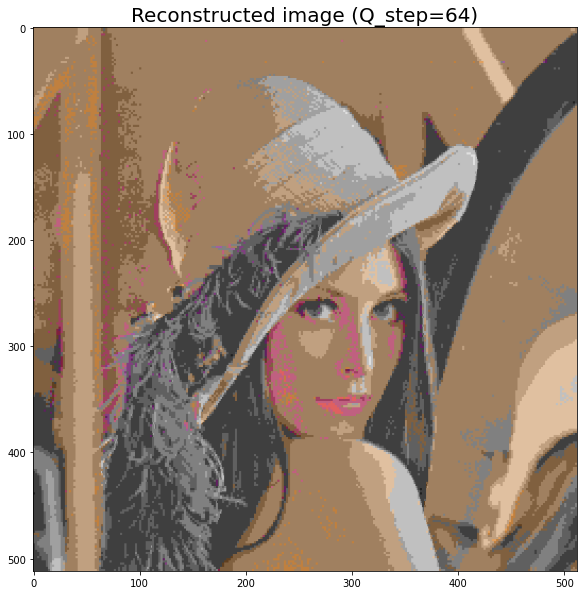

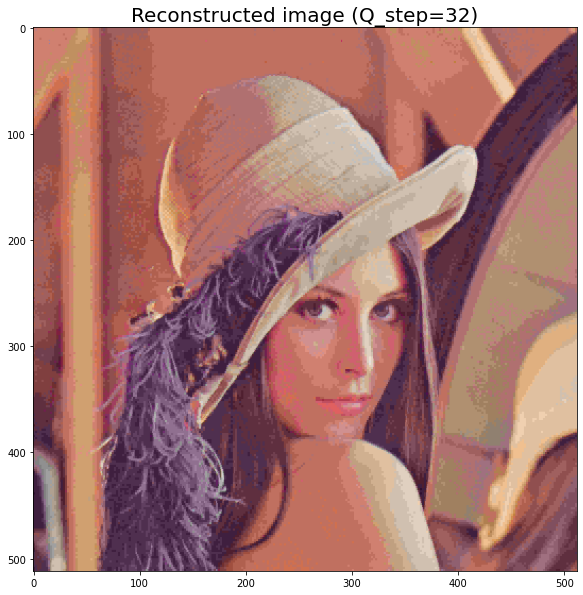

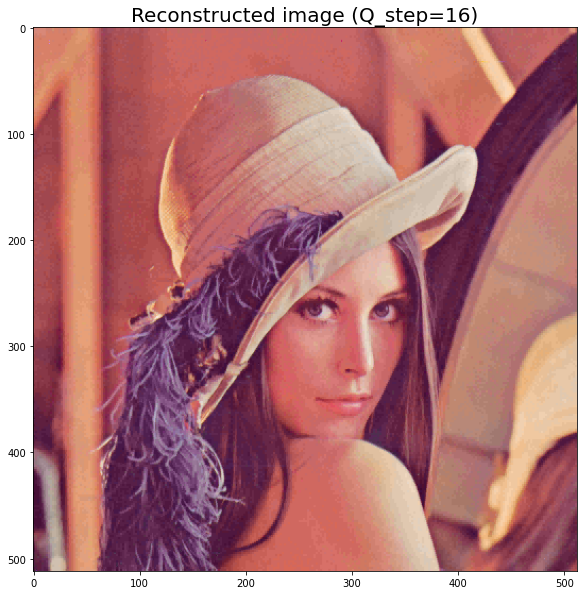

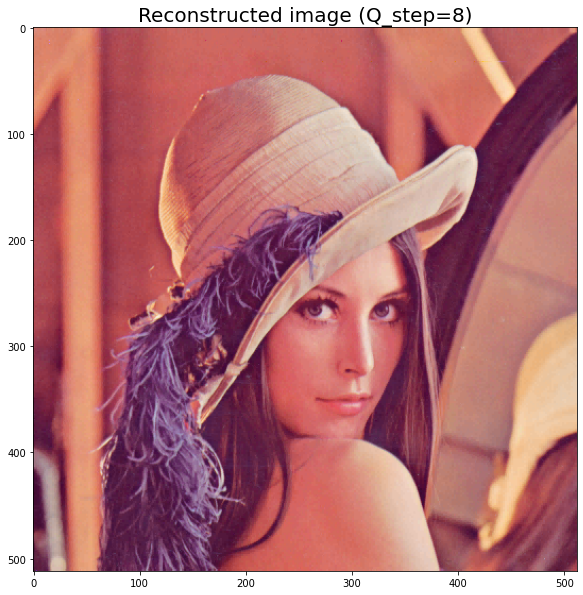

In [28]:
#x = image.read(test_image)
xx = YUV.from_RGB(x.astype(np.int16) - 128)
#xx = YUV.from_RGB(x.astype(np.int16))

DWT_points = []
for Q_step in Q_steps:
    yy = DWT.analyze(xx, wavelet, N_levels)
    LL = yy[0]
    LL_k = Q.quantize(LL, Q_step)
    LL_dQ = Q.dequantize(LL_k, Q_step)
    yy_k = [LL_k]
    yy_dQ = [LL_dQ]
    #dist = distortion.MSE(LL, LL_dQ)
    #MSE = (dist * LL.size)/x.size
    #print(gains[0], dist, gains[0] * dist, MSE)
    #for i in range(4):
    #    for j in range(4):
    #        print(LL[i, j], LL_dQ[i, j])
    for sr in yy[1:]:
        sr_k = []
        sr_dQ = []
        for sb in sr:
            #print(MSE)
            sb_k = Q.quantize(sb, Q_step)
            sb_dQ = Q.dequantize(sb_k, Q_step)
            sr_k.append(sb_k)
            sr_dQ.append(sb_dQ)
            #dist = distortion.MSE(sb, sb_dQ)
            #print(gains[counter], dist, gains[counter] * dist, MSE)
            #MSE += (dist * sb.size)/x.size
        yy_k.append(tuple(sr_k))
        yy_dQ.append(tuple(sr_dQ))
    BPP = (write_compact_decomposition(yy_k, f"/tmp/constant_{Q_step}_", 0)*8)/xx.size
    zz_dQ = DWT.synthesize(yy_dQ, wavelet, N_levels)
    #z_dQ = np.clip(YUV.to_RGB(zz_dQ), a_min=-128, a_max=127) + 128
    z_dQ = np.clip(YUV.to_RGB(zz_dQ) + 128, a_min=0, a_max=255)
    MSE = distortion.MSE(x, z_dQ)
    print(f"{Q_step} {BPP} {MSE}")
    DWT_points.append((BPP, MSE))
    image.show(z_dQ.astype(np.uint8), f"Reconstructed image (Q_step={Q_step})")